In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
file_name = 'IMDB Dataset.csv'
df = pd.read_csv(file_name)
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


train data shape: 37500
test data shape: 12500


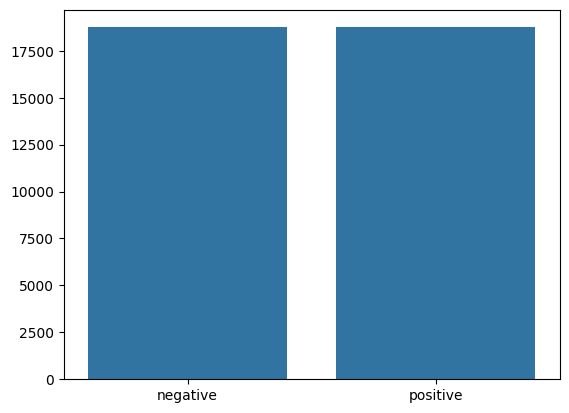

In [4]:
# Replace df with your actual DataFrame if it's different
X, y = df['review'].values, df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(f'train data shape: {len(x_train)}')
print(f'test data shape: {len(x_test)}')

dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative', 'positive']), y=dd.values)
plt.show()

# # Convert y_train and y_test to lists (optional)
y_train = y_train.tolist()
y_test = y_test.tolist()


In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [6]:
import re

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # Replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

In [7]:
import torch
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.corpus import stopwords
from collections import Counter


def tokenize(x_train, y_train, x_val, y_val, max_length):
    word_list = []

    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
 
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}
   
    # tokenize
    final_list_train = []
    for sent in x_train:
        tokens = [onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()]
        final_list_train.append(tokens)
           
    final_list_test = []
    for sent in x_val:
        tokens = [onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()]
        final_list_test.append(tokens)

    # Pad sequences to a fixed length with pre-padding
    x_train_padded = pad_sequence([torch.tensor(tokens) for tokens in final_list_train], batch_first=True, padding_value=0)
    x_val_padded = pad_sequence([torch.tensor(tokens) for tokens in final_list_test], batch_first=True, padding_value=0)
    
    encoded_train = [1 if label == 'positive' else 0 for label in y_train]  
    encoded_test = [1 if label == 'positive' else 0 for label in y_val]
    
    return x_train_padded, torch.tensor(encoded_train), x_val_padded, torch.tensor(encoded_test), onehot_dict

max_length = 500  
x_train, y_train, x_test, y_test, vocab = tokenize(x_train, y_train, x_test, y_test, max_length)


<Axes: >

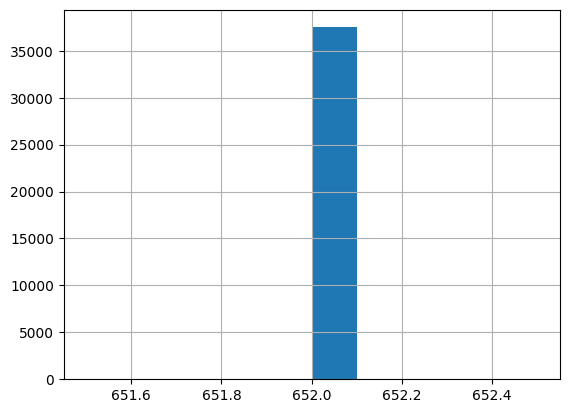

In [8]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()

In [9]:
# Not required as the padding was done together in the previous step.

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
valid_data = TensorDataset(torch.tensor(x_test), torch.tensor(y_test))


# dataloaders
batch_size = 50


# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 652])
Sample input: 
 tensor([[ 38, 122,  44,  ...,   0,   0,   0],
        [263,  79, 552,  ...,   0,   0,   0],
        [  3, 127, 605,  ...,   0,   0,   0],
        ...,
        [277,   2,  26,  ...,   0,   0,   0],
        [  2, 497, 124,  ...,   0,   0,   0],
        [  4, 657,  44,  ...,   0,   0,   0]])
Sample output: 
 tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1])


C:\Users\bhave\AppData\Local\Temp\ipykernel_16020\2978673069.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
C:\Users\bhave\AppData\Local\Temp\ipykernel_16020\2978673069.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_data = TensorDataset(torch.tensor(x_test), torch.tensor(y_test))


In [11]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
   
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
       
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
       
        # dropout layer
        self.dropout = nn.Dropout(0.5)
   
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
       
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
       
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
       
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
       
        # sigmoid function
        sig_out = self.sig(out)
       
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)


        sig_out = sig_out[:, -1] # get last batch of labels
       
        # return last sigmoid output and hidden state
        return sig_out, hidden
       
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden 

In [12]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob=0.5)

# Moving model to device
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [13]:
# loss and optimization functions

lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [14]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
       
        inputs, labels = inputs.to(device), labels.to(device)  
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
       
        model.zero_grad()
        output,h = model(inputs,h)
       
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
       
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])


            inputs, labels = inputs.to(device), labels.to(device)


            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())


            val_losses.append(val_loss.item())
           
            accuracy = acc(output,labels)
            val_acc += accuracy
           
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6936964178880056 val_loss : 0.6937393989562989
train_accuracy : 50.01866666666667 val_accuracy : 50.0
Validation loss decreased (inf --> 0.693739).  Saving model ...
Epoch 2
train_loss : 0.6933180103302002 val_loss : 0.6933089816570281
train_accuracy : 50.13066666666667 val_accuracy : 50.0
Validation loss decreased (0.693739 --> 0.693309).  Saving model ...
Epoch 3
train_loss : 0.6933430463473003 val_loss : 0.6931715936660766
train_accuracy : 50.117333333333335 val_accuracy : 50.007999999999996
Validation loss decreased (0.693309 --> 0.693172).  Saving model ...
Epoch 4
train_loss : 0.6933422512213389 val_loss : 0.693171635389328
train_accuracy : 49.68533333333333 val_accuracy : 50.007999999999996
Epoch 5
train_loss : 0.6932283991972605 val_loss : 0.6931302540302277
train_accuracy : 50.032 val_accuracy : 50.007999999999996
Validation loss decreased (0.693172 --> 0.693130).  Saving model ...
Epoch 6
train_loss : 0.693204285621643 val_loss : 0.6931235067844391
trai

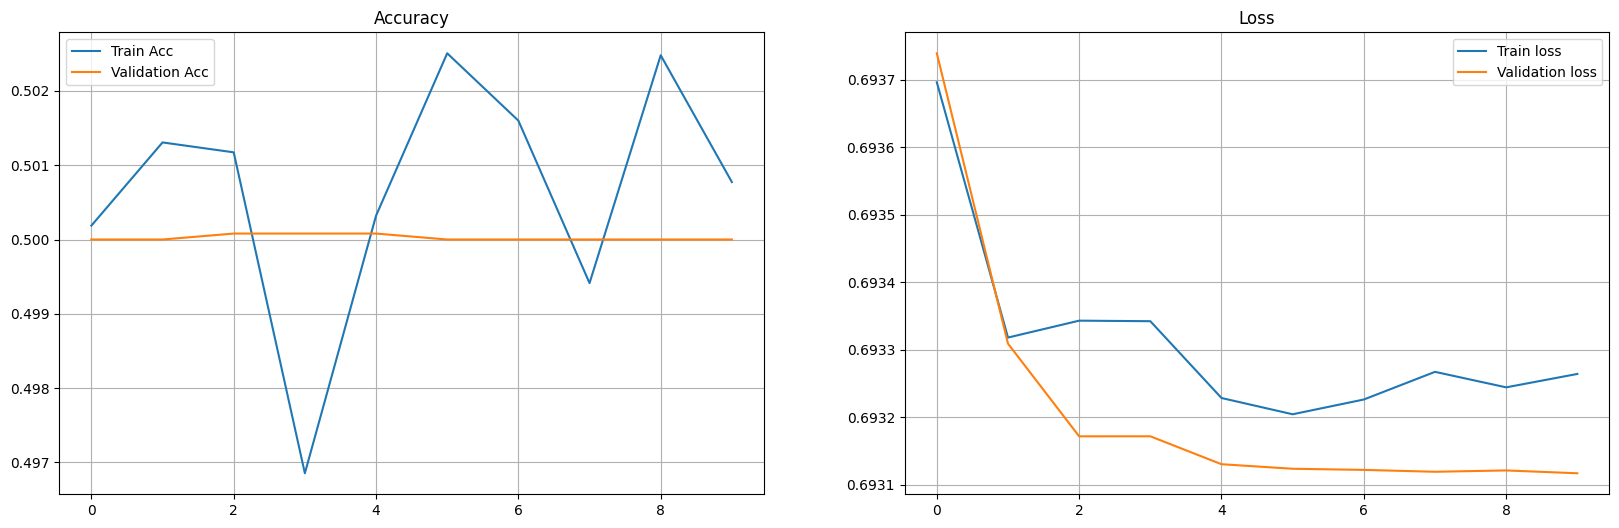

In [17]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
   
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()


plt.show()

In [18]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())


index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')


Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve